## Parameter search for pupil tracking

objc[40694]: Class CaptureDelegate is implemented in both /Users/jiwoongpark/anaconda3/envs/Eyetracking/lib/python3.11/site-packages/cv2/cv2.abi3.so (0x307372520) and /opt/homebrew/Cellar/opencv/4.10.0_9/lib/libopencv_videoio.4.10.0.dylib (0x309844880). One of the two will be used. Which one is undefined.
objc[40694]: Class CVWindow is implemented in both /Users/jiwoongpark/anaconda3/envs/Eyetracking/lib/python3.11/site-packages/cv2/cv2.abi3.so (0x307372570) and /opt/homebrew/Cellar/opencv/4.10.0_9/lib/libopencv_highgui.4.10.0.dylib (0x308ae4b28). One of the two will be used. Which one is undefined.
objc[40694]: Class CVView is implemented in both /Users/jiwoongpark/anaconda3/envs/Eyetracking/lib/python3.11/site-packages/cv2/cv2.abi3.so (0x307372598) and /opt/homebrew/Cellar/opencv/4.10.0_9/lib/libopencv_highgui.4.10.0.dylib (0x308ae4b50). One of the two will be used. Which one is undefined.
objc[40694]: Class CVSlider is implemented in both /Users/jiwoongpark/anaconda3/envs/Eyetrackin

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.97222221
 0.97222221 0.97222221 0.94444442 0.91666669 0.91666669 0.91666669
 0.91666669 0.91666669 0.8888889  0.8888889  0.8888889  0.8611111
 0.8611111  0.77777779 0.25       0.22222222 0.16666667 0.08333334]


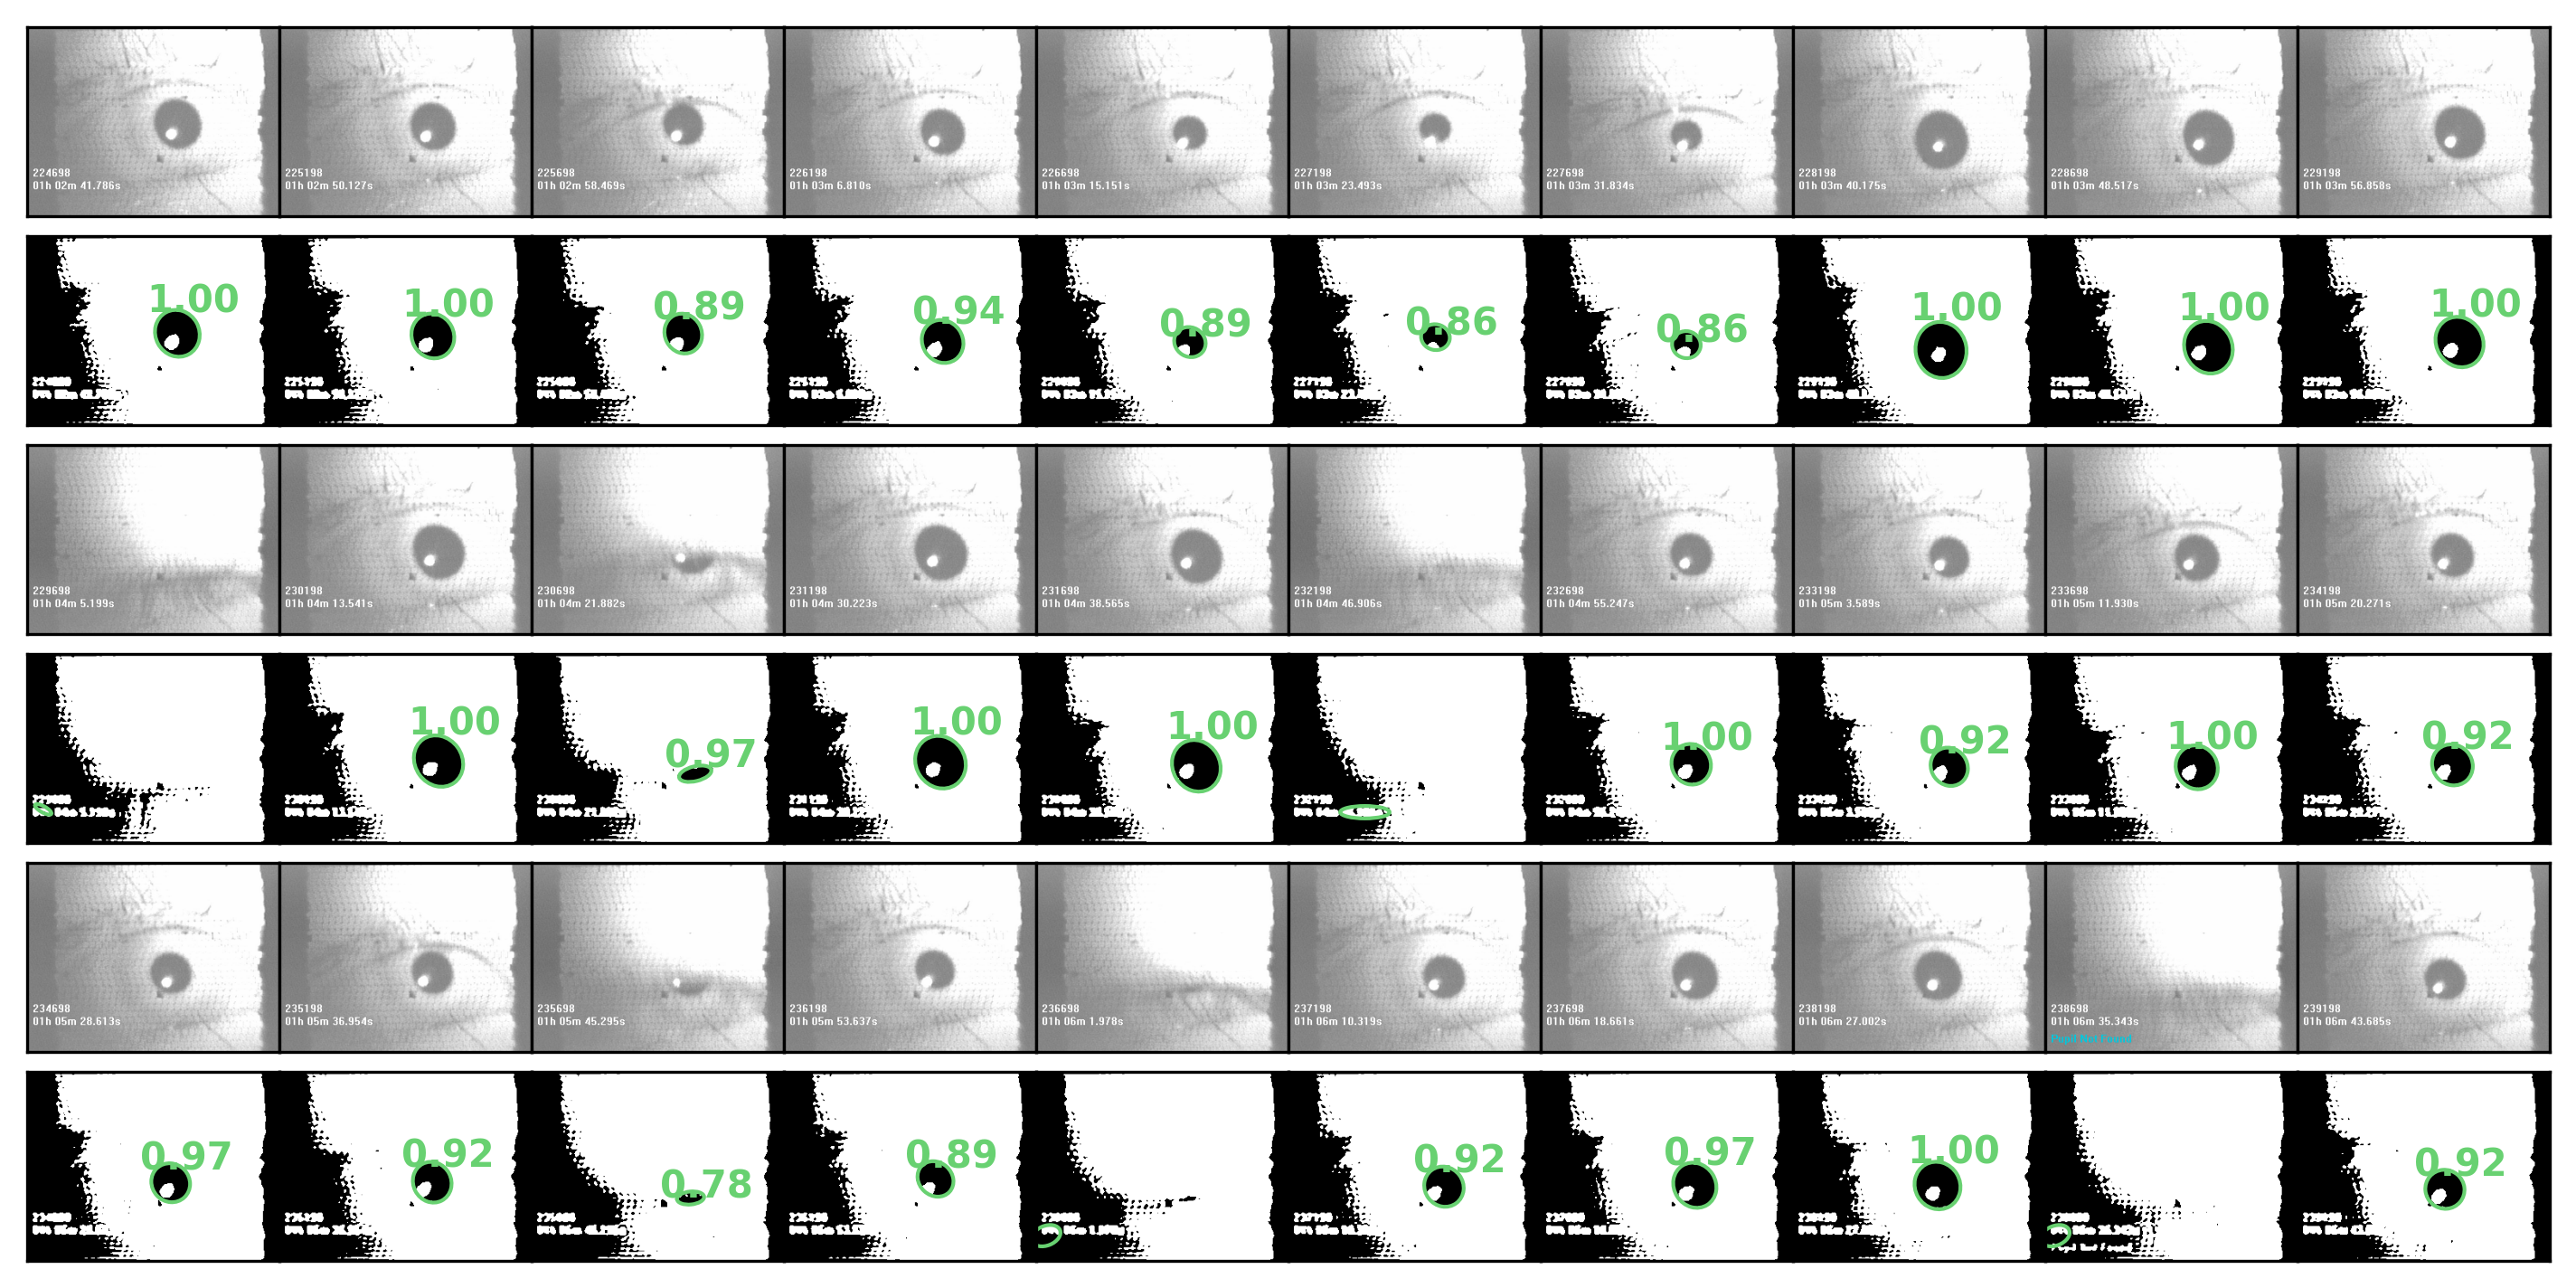

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import eyerec
from matplotlib.patches import Ellipse
plt.style.use('default')

subject = 'sub-001'
session = 'ses-01'
task = 'task-example'
run = 'run-1'

alpha = 1.0
binarize_threshold = 80  # parameter for binarization
mask_size = 40           # parameter for low-pass filtering mask
magnification = True

filename = f'/Volumes/HAZE/eyetracking/{subject}/{session}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_mv.avi'
capture = cv2.VideoCapture(filename)
read, frame = capture.read()

rows, cols = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).shape
crow,ccol = rows//2 , cols//2
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-mask_size:crow+mask_size, ccol-mask_size:ccol+mask_size] = 1

count = 0

original_frames = []
binarized_frames = []
tracker = eyerec.PupilTracker(name='purest')
tracker.set_min_pupil_diameter_px(diameter=0)

n_figures = 10
padding = 20
fig, axes = plt.subplots(6, n_figures,figsize=(12,6), dpi=300,sharex=True, sharey=True)
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])

i = 0
row = 0
mean_size = []
mean_confidence = []
while read:
    if count % 500 == 0:
        original_frames.append(frame)
    
        frame[np.logical_and(frame[:,:,2]>200, np.mean(frame[:,:,0:2], axis=-1) < 50), 0:2] = 255
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # FFT
        dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)
        fshift = dft_shift*mask
        f_ishift = np.fft.ifftshift(fshift)
        frame_back = cv2.idft(f_ishift)
        frame_back = cv2.magnitude(frame_back[:,:,0],frame_back[:,:,1])
        frame_back = (frame_back - frame_back.min()) / (frame_back.max() - frame_back.min())
        frame_back = np.clip(frame_back*255.0, 0, 255).astype(np.uint8)
        
        _, frame_back = cv2.threshold(frame_back, binarize_threshold, 255, cv2.THRESH_BINARY)
        frame_back_padding = cv2.copyMakeBorder(frame_back, 
                                                padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        pupil = tracker.detect(capture.get(cv2.CAP_PROP_POS_MSEC), frame_back_padding)
        
        row = 2*(i//n_figures) 
        axes[0+row,i%n_figures].imshow(original_frames[-1])
        axes[1+row,i%n_figures].imshow(frame_back, cmap='Greys_r')
        ellipse = Ellipse(xy=(pupil['center'][0]-padding,pupil['center'][1]-padding), 
                          width=pupil['size'][0], 
                          height=pupil['size'][1],
                          angle=pupil['angle'], 
                          facecolor='none', edgecolor='#68d171')
        axes[1+row,i%n_figures].add_patch(ellipse)
        if pupil['confidence'] > 0.4:
            axes[1+row,i%n_figures].text(x=pupil['center'][0],
                                         y=pupil['center'][1] - pupil['size'][1],
                                         s=f"{pupil['confidence']:.2f}", color='#68d171', 
                                         fontweight='bold', ha='center', va='center')
        if pupil['confidence'] >= 0.90:
            mean_size.append(np.max([pupil['size']]))
        mean_confidence.append(pupil['confidence'])
        
        i += 1
    read, frame = capture.read()
    count += 1
    if i >= n_figures*3:
        break

plt.subplots_adjust(hspace=0.001, wspace=0.001)
print(np.sort(mean_confidence)[::-1])

## Copy files and Pupil detection

In [2]:
import os
import time
import pandas as pd
import shutil
import glob

pupil_minmax = True

if pupil_minmax:
    min_size = 0.5*np.mean(mean_size)
    max_size = 2.0*np.mean(mean_size)

print(subject, session, task, run)
dir_path = f'_DATA/{subject}/{session}/'
if not os.path.exists(dir_path):
    os.mkdir(dir_path)

df = pd.DataFrame(columns=['diameter_px','width_px','height_px','axisRatio',
                           'center_x','center_y', 'angle_deg', 'confidence'])
df.head()

eyetracking_file_extensions = ['dat.txt', 'his.txt', 'ev.txt']

for ext in eyetracking_file_extensions:
    copy_filename =  f'/Volumes/HAZE/eyetracking/{subject}/{session}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_{ext}'
    if copy_filename not in glob.glob(f'{dir_path}*'):
        shutil.copy(copy_filename, dir_path)

filename = f'/Volumes/HAZE/eyetracking/{subject}/{session}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_mv.avi'
capture = cv2.VideoCapture(filename)

    
read, frame = capture.read()
rows, cols = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).shape
crow,ccol = rows//2 , cols//2
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-mask_size:crow+mask_size, ccol-mask_size:ccol+mask_size] = 1

tracker = eyerec.PupilTracker(name='purest')
if pupil_minmax:
    tracker.set_min_pupil_diameter_px(diameter=min_size)
    tracker.set_max_pupil_diameter_px(diameter=max_size)

count = 0
time_sta = time.time()
while read:    
    frame[np.logical_and(frame[:,:,2]>200, np.mean(frame[:,:,0:2], axis=-1) < 50), 0:2] = 255
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    frame_back = cv2.idft(f_ishift)
    frame_back = cv2.magnitude(frame_back[:,:,0],frame_back[:,:,1])
    frame_back = (frame_back - frame_back.min()) / (frame_back.max() - frame_back.min())
    frame_back = np.clip(frame_back*255.0, 0, 255).astype(np.uint8)

    _, frame_back = cv2.threshold(frame_back, binarize_threshold, 255, cv2.THRESH_BINARY)
    frame_back_padding = cv2.copyMakeBorder(frame_back, 
                                            padding, padding, 
                                            padding, padding, 
                                            cv2.BORDER_CONSTANT, value=[255, 255, 255])
    pupil = tracker.detect(capture.get(cv2.CAP_PROP_POS_MSEC), frame_back_padding)

    df.loc[count] = {'diameter_px':np.max([pupil['size']]),
                     'width_px':pupil['size'][0],
                     'height_px':pupil['size'][1],
                     'axisRatio':np.min([pupil['size']])/np.max([pupil['size']]),
                     'center_x':pupil['center'][0] - padding,
                     'center_y':pupil['center'][1] - padding,
                     'angle_deg': pupil['angle'],
                     'confidence':pupil['confidence'],
                     }
    
    read, frame = capture.read()
    if count % 1000 == 0 and count > 0:
        time_duration = time.time() - time_sta
        print(f"Processed:{count} / FPS:{1000/time_duration:3.1f} / Elapsed:{time_duration:3.1f}s")
        time_sta = time.time()
    count += 1
print(subject, session, task, run, count)

sub-024 ses-13A task-mcHERDING run-1
Processed:1000 / FPS:263.6 / Elapsed:3.8s
Processed:2000 / FPS:291.7 / Elapsed:3.4s
Processed:3000 / FPS:309.0 / Elapsed:3.2s
Processed:4000 / FPS:300.3 / Elapsed:3.3s
Processed:5000 / FPS:280.7 / Elapsed:3.6s
Processed:6000 / FPS:277.8 / Elapsed:3.6s
Processed:7000 / FPS:278.1 / Elapsed:3.6s
Processed:8000 / FPS:278.2 / Elapsed:3.6s
Processed:9000 / FPS:276.9 / Elapsed:3.6s
Processed:10000 / FPS:273.4 / Elapsed:3.7s
Processed:11000 / FPS:282.0 / Elapsed:3.5s
Processed:12000 / FPS:277.5 / Elapsed:3.6s
Processed:13000 / FPS:278.7 / Elapsed:3.6s
Processed:14000 / FPS:273.6 / Elapsed:3.7s
Processed:15000 / FPS:261.9 / Elapsed:3.8s
Processed:16000 / FPS:247.9 / Elapsed:4.0s
Processed:17000 / FPS:270.8 / Elapsed:3.7s
Processed:18000 / FPS:262.7 / Elapsed:3.8s
Processed:19000 / FPS:265.0 / Elapsed:3.8s
Processed:20000 / FPS:266.5 / Elapsed:3.8s
Processed:21000 / FPS:255.2 / Elapsed:3.9s
Processed:22000 / FPS:248.0 / Elapsed:4.0s
Processed:23000 / FPS:257.

## Visual inspection of pupil data

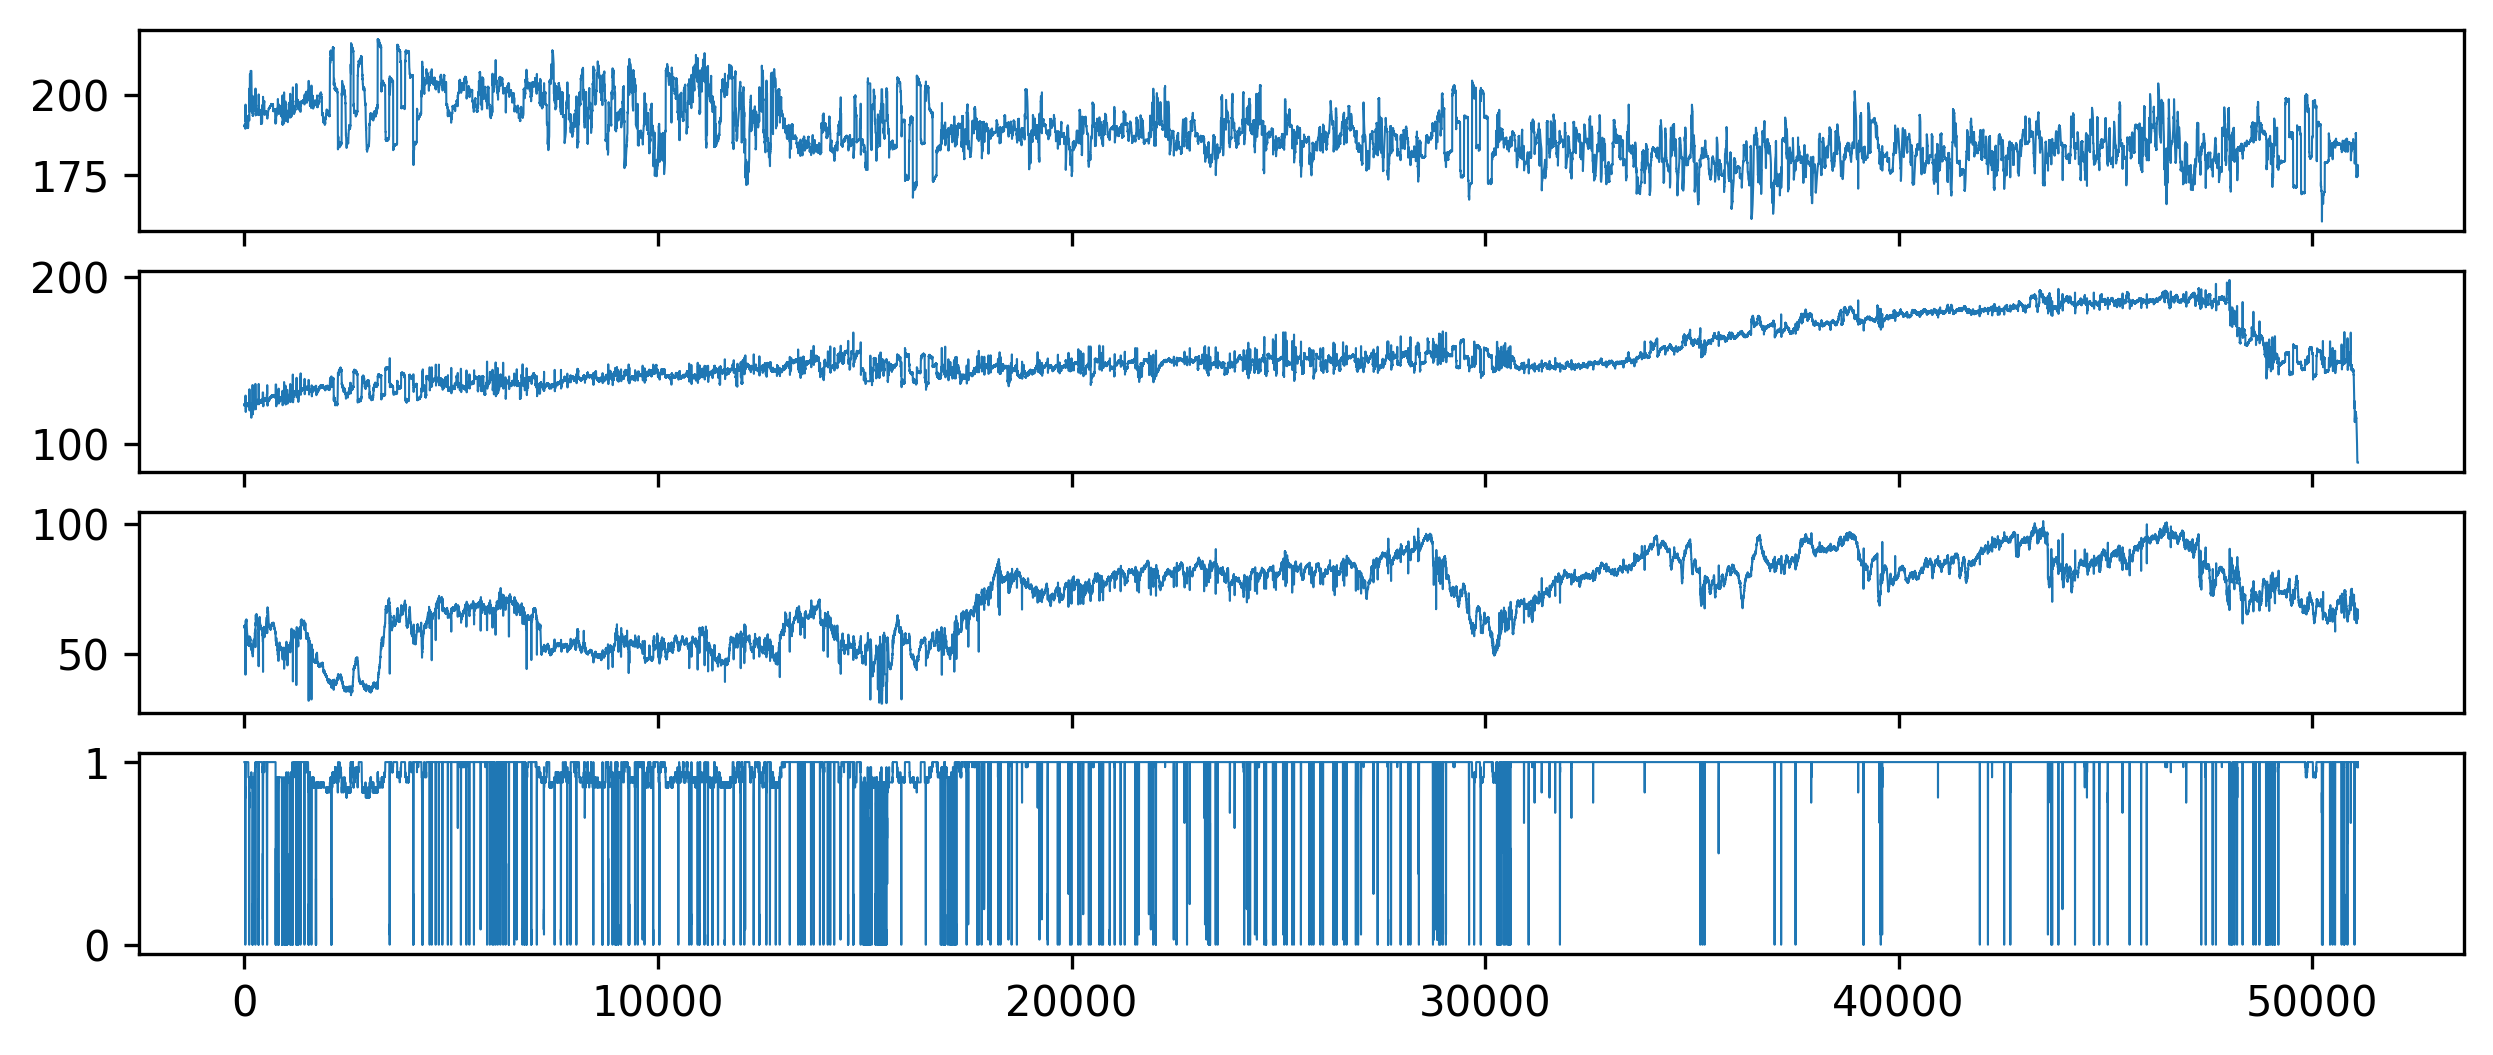

In [3]:
min_size = 0.2 * np.mean(mean_size)
max_size = 2.0 * np.mean(mean_size)
window = 1000
z = 3.0
confidence_threshold = 0.8

pupil_y = np.copy(df['center_y'].to_numpy())
for i in range(len(pupil_y) - 1):
    if df['confidence'][i + 1] < confidence_threshold:
        pupil_y[i + 1] = pupil_y[i]
for i in range(len(pupil_y) - 1):
    start_idx = max(i - window // 2, 0)
    end_idx = min(i + window // 2, len(pupil_y))
    local_mean = np.mean(pupil_y[start_idx:end_idx])
    local_std = np.std(pupil_y[start_idx:end_idx])
    if (np.logical_or(df['diameter_px'][i + 1] < min_size, df['diameter_px'][i + 1] > max_size) or
        np.logical_or(pupil_y[i + 1] < (local_mean - z * local_std), pupil_y[i + 1] > (local_mean + z * local_std))):
        pupil_y[i + 1] = pupil_y[i]        

for i in range(100):
    if pupil_y[i] <= 0:
        pupil_y[i] = np.median(pupil_y)

pupil_x = np.copy(df['center_x'].to_numpy())
for i in range(len(pupil_x) - 1):
    if df['confidence'][i + 1] < confidence_threshold:
        pupil_x[i + 1] = pupil_x[i]
for i in range(len(pupil_x) - 1):
    start_idx = max(i - window // 2, 0)
    end_idx = min(i + window // 2, len(pupil_x))
    local_mean = np.mean(pupil_x[start_idx:end_idx])
    local_std = np.std(pupil_x[start_idx:end_idx])
    if (np.logical_or(df['diameter_px'][i + 1] < min_size, df['diameter_px'][i + 1] > max_size) or
        np.logical_or(pupil_x[i + 1] < (local_mean - z * local_std), pupil_x[i + 1] > (local_mean + z * local_std))):
        pupil_x[i + 1] = pupil_x[i]        

for i in range(100):
    if pupil_x[i] <= 0:
        pupil_x[i] = np.median(pupil_x)

pupil_diameter = np.copy(df['diameter_px'].to_numpy())
for i in range(len(pupil_diameter) - 1):
    if df['confidence'][i + 1] < confidence_threshold:
        pupil_diameter[i + 1] = pupil_diameter[i]
for i in range(len(pupil_diameter) - 1):
    start_idx = max(i - window // 2, 0)
    end_idx = min(i + window // 2, len(pupil_diameter))
    local_mean = np.mean(pupil_diameter[start_idx:end_idx])
    local_std = np.std(pupil_diameter[start_idx:end_idx])
    if np.logical_or(pupil_diameter[i + 1] < (local_mean - z * local_std), pupil_diameter[i + 1] > (local_mean + z * local_std)):
        pupil_diameter[i + 1] = pupil_diameter[i]   
        
for i in range(100):
    if pupil_diameter[i] <= 0:
        pupil_diameter[i] = np.median(pupil_diameter)
        
fig, axes = plt.subplots(4, 1, figsize=(10, 4), dpi=300, sharex=True)
axes[0].plot(pupil_x, lw=0.5)
axes[1].plot(pupil_y, lw=0.5)
axes[2].plot(pupil_diameter, lw=0.5)
axes[3].plot(df['confidence'], lw=0.5)

## Save the pupil data

In [4]:
df['center_x'] = pupil_x
df['center_y'] = pupil_y
df['diameter_px'] = pupil_diameter
print(subject, session, task, run)
target_filename = f'{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
df.to_csv(f'{dir_path}/{target_filename}', index=False)

sub-024 ses-13A task-mcHERDING run-1
